# AI for Earth System Science Hackathon 2020
# GECKO-A Emulation
David John Gagne, Siyuan Wang, Charlie Becker, Keely Lawrence, Alma Hodzic, Natasha Flyer

## Introduction
![GECKO](https://github.com/NCAR/ai4ess-hackathon-2020/blob/master/notebooks/gecko_image.png?raw=1)
Natural and anthropogenic sources emit a large number of volatile organic compounds (VOCs). These compounds greatly affect the “self-cleaning capacity” of the atmosphere. These compounds can also undergo complicated chemical and physical processes in the atmosphere, forming organic aerosols. Organic aerosols have significant direct (absorbing/scattering) and indirect (affect cloud formation/properties) radiation effect.

In order to understand the broad impacts of VOCs on air quality and climate, we need to understand their sources and fates in the atmosphere. Many of these compounds can be directly emitted, or be produced from other compounds; in the meantime, they can undergo a variety of chemical reactions in the atmosphere. The chemical mechanism of these VOCs in the atmosphere can be very highly complicated, especially involving the formation of organic aerosols.

Most air quality models or chemistry-climate models are equipped with chemical mechanisms consisting of hundreds-thousands of chemical reactions. It is often found that such simplified chemical mechanisms are incapable to describe the complicity in the atmosphere. A widely used “near-explicit” chemical mechanism (Master Chemical Mechanism) consists of tens of thousands of chemical reactions, which still cannot capture the behavior and characteristics of the formation of organic aerosols. Such “near-explicit” mechanism is too computationally demanding for most air quality models or chemistry-climate models already.

NCAR (USA) and Centre National de la Recherche Scientifique (CNRS, France) jointly developed a hyper-explicit chemical mechanism: Generator of Explicit Chemistry and Kinetics of Organics in the Atmosphere (GECKO-A). GECKO-A can generate chemical mechanisms based on how the molecules/bonds/atoms interact with each other. Chemical mechanisms generated by GECKO-A usually include millions to tens of millions of reactions. Due to the remarkable computational cost, no air quality models or chemistry-climate models can afford to run with GECKO-A in the foreseeable future. There is a growing interest in the community to implement such complicated mechanisms into air quality models or chemistry-climate models, to study the broader impacts on air quality, human health, and the climate system.

Machine‐learning and artificial intelligence have proven to be a valuable tool in atmospheric science. Recent years have seen quite a few inspiring applications in developing machine-learning emulators using explicit/process-level models and implementing the trained emulators into large-scale models. Such explicit/process-level models are otherwise too expensive for large-scale models.

The goal of this project is to train the machine-learning emulator using the “library” generated by the hyper-explicit chemical mechanism, GECKO-A. 


## Software Requirements
This notebook requires Python >= 3.7. The following libraries are required:
* numpy
* scipy
* matplotlib
* xarray
* pandas
* scikit-learn
* tensorflow >= 2.1
* netcdf4
* tqdm

In [ ]:
! pip install numpy scipy matplotlib xarray pandas netcdf4 tqdm tensorflow scikit-learn seaborn

You should consider upgrading via the '/glade/work/cbecker/ncar_20191211/bin/python3.7 -m pip install --upgrade pip' command.


In [ ]:
pip install --upgrade pandas

Requirement already up-to-date: pandas in /glade/work/cbecker/ncar_20191211/lib/python3.7/site-packages (1.0.5)
You should consider upgrading via the '/glade/work/cbecker/ncar_20191211/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import s3fs
import seaborn as sns
import pandas as pd
import pyarrow
import re
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from os.path import join, exists
from matplotlib.colors import LogNorm
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from sklearn.model_selection import GroupKFold
from tensorflow.keras.optimizers import Adam
%matplotlib inline

seed = 8886
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data
 **Data generation procedure**: The machine-learning training dataset in this project (or library) is generated by the hyper-explicit chemical mechanism, GECKO-A. This library consists of results from thousands of GECKO-A simulations under vastly different conditions. More information about GECKO-A can be found [here](https://www2.acom.ucar.edu/modeling/gecko). Each model run lasts 5 simulation days.
 
 ### Potential Input Variables
* Temperature (K): The temperature at which the GECKO-A experiments were conducted. Temperature will affect the reaction rates of many reactions. It also affects the partitioning of a given compound between the gas-phase and particle-phase.
* Solar zenith angle (degree): The solar zenith angle at which the GECKO-A experiments were conducted. This will affect the photolysis reactions. 
* Pre-existing aerosols (micrograms per cubic meter): Depending on the environmental conditions (e.g., temperature) and the vapor pressure, a compound can deposit onto (pre-existing) aerosols or evaporate from the aerosols. 
* NOx (ppb): concentration of nitrogen oxides. These are important compounds in the atmosphere, affecting the chemical mechanisms of many volatile organic compounds.
* O3 (ppb): concentration of ozone. It’s another important compounds in the atmosphere, affecting the chemical mechanisms of many VOCs.
* OH (10^6 molecules per cubic centimeter): concentration of hydroxyl radicals (OH). It’s one of the most important oxidants in the atmosphere, largely driving the oxidation of many VOCs.

### Output Variables
* Precursor (micrograms per cubic meter): time series of the VOC precursor. We call it “precursor” because it’ll undergo chemical reactions and produce other compounds.
* Gas (micrograms per cubic meter): mass concentration of products in the gas-phase.
* Aerosol (micrograms per cubic meter): mass concentration of products in the aerosol-phase.

### Metadata

| Metadata | Units | Label | 
| ------------- | :----:|:----------- | 
| Number Experiments   | 2000     | id | 
| Total Timesteps   | 1440     | Time |
| Timestep Delta   | 300 seconds | - |


### Potential Input Variables

| Variable Name | Units | Type | 
| ------------- | :----:|:----------- | 
| Precursor  | ug/m3     | Varies | 
| Gas   | ug/m3     | Varies   |
| Aerosol   | ug/m3     | Varies |
| Temperature   | K     | Static         |
| Solar Zenith Angle   | degree     | Static        |
| Pre-existing Aersols   | ug/m3     | Static         |
| o3  | ppb     | Static         |
| nox   | ppb     | Static         |
| oh   | 10^6 molec/cm3     | Static         |

### Potential Output Variables

| Variable Name | Units | Type | 
| ------------- | :----:|:----------- | 
| Precursor (at t+1) | ug/m3     | Varies | 
| Gas   (at t+1)  | ug/m3   | Varies   |
| Aerosol (at t+1)  | ug/m3     | Varies |

### Training, validation, and testing sets
This training dataset/library consists of 2000 GECKO experiments, including results for 5 day runs (1440 timesteps at 300 second intervals). The data has already been split into training/validation/test sets by random expiriments of size 1400/200/200 (and 200 for a hidden test set). Thus, the training set consists of 2,016,000 samples of data and test/validation sets with 288,000 samples.

In [2]:
# -----------------------------------------------
""" Data Processing """

def fetch_data(f):
    """ Load data directly from Amazon S3 storage """
    
    obj = fs.open(f)
    df = pd.read_parquet(obj)
    return df

def prepare_data(data, input_columns, output_columns):
    """ Splits data to input/output with corresponding lag """
    
    data['id'] = data['id'].apply(lambda x: int(x[3:])) # change expnumber to int for sorting
    data.index.name = 'indx'
    data = data.sort_values(['id','indx'])
    x_data = data[input_columns].iloc[:-1, :]
    y_data = data[output_columns].iloc[1:, :]
    
    return x_data, y_data

def get_starting_conds(data, input_vars, exp, starting_ts=0):
    """ Take data and expiriment number to gather initial starting condition for box emulator"""
    exp_data = data[data['id'] == exp]
    
    if exp_data.shape[0] == 0:
        raise ValueError('That expiriment number does not exist in this dataset.')
    
    ts_data = exp_data.iloc[starting_ts:starting_ts+1, :]

    return ts_data
# -----------------------------------------------
""" Evaluation """

def calc_pdf_hist(x, x_bins):
    return np.histogram(x, x_bins, density=True)[0]

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def hellinger(x, pdf_p, pdf_q):
    pdf_distances = (np.sqrt(pdf_p) - np.sqrt(pdf_q)) ** 2
    return np.trapz(pdf_distances, x) / 2

def hellinger_distance(y_true, y_pred, bins=50):
    bin_points = np.linspace(np.minimum(y_true.min(), y_pred.min()),
                       np.maximum(y_true.max(), y_pred.max()),
                       bins)
    bin_centers = 0.5 * (bin_points[:-1] + bin_points[1:])
    y_true_pdf = calc_pdf_hist(y_true, bin_points)
    y_pred_pdf = calc_pdf_hist(y_pred, bin_points)
    return hellinger(bin_centers, y_true_pdf, y_pred_pdf)

def r2_corr(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0, 1] ** 2

def evaluate_mod(true_output, model_results):
    
    print('RMSE: Precursor: {:.5f}, Gas: {:.5f}, Aerosols: {:.5f}'.format(
        rmse(true_output.iloc[:,0], model_results.iloc[:,0]),
        rmse(true_output.iloc[:,1], model_results.iloc[:,1]),
        rmse(true_output.iloc[:,2], model_results.iloc[:,2])))
    print('R2: Precursor: {:.5f}, Gas: {:.5f}, Aerosols: {:.5f}'.format(
        r2_corr(true_output.iloc[:,0], model_results.iloc[:,0]),
        r2_corr(true_output.iloc[:,1], model_results.iloc[:,1]),
        r2_corr(true_output.iloc[:,2], model_results.iloc[:,2])))
    print('Hellenger Distance: Precursor: {:.5f}, Gas: {:.5f}, Aerosols: {:.5f}'.format(
        hellinger_distance(true_output.iloc[:,0], model_results.iloc[:,0]),
        hellinger_distance(true_output.iloc[:,1], model_results.iloc[:,1]),
        hellinger_distance(true_output.iloc[:,2], model_results.iloc[:,2])))
    
    return
# -----------------------------------------------
""" Models """
def dense_neural_net(num_layers=2, num_neurons=100, activation="relu", learning_rate=0.001,
                     num_input_columns=9, num_output_columns=3):
    """ Build and return dense neural network with specified hyperparameters"""
    
    input_layer = Input(num_input_columns)
    n_net = input_layer
    for l in range(num_layers):
        n_net= Dense(num_neurons, activation=activation)(n_net)
    out = Dense(num_output_columns)(n_net)
    mod = Model(input_layer, out)
    mod.compile(Adam(learning_rate=learning_rate), "mse")
    
    return mod

def box_emulator(neural_network, starting_conds, input_scaler, output_scaler, num_timesteps=1439):
    """ Forward box emulator
    Args:
        neural_netwrok: NN model object that predits output at t+1
        starting_conds: Initial input conditions used for first prediction
        input_scaler: Input scaler object
        onput_scaler: Onput scaler object
        num_timesteps: how many timesteps forward to run emulator
    Returns:
        results: Pandas DataFrame of box emulator output
    """
    mod = neural_network
    scaled_input = input_scaler.transform(starting_conds.iloc[:,1:-1])
    static_input = scaled_input[:,-6:]

    for i in range(num_timesteps):

        if i == 0:

            pred = mod.predict(scaled_input)
            new_input = np.concatenate([pred,static_input], axis=1)
            pred_array = pred

        else:

            pred = mod.predict(new_input)
            new_input = np.concatenate([pred,static_input], axis=1)
            pred_array = np.concatenate([pred_array, pred], axis=0)
            
    results = pd.DataFrame(output_scaler.inverse_transform(pred_array))
    results['id'] = starting_conds.iloc[0,-1]
    results.columns = starting_conds.columns[[1,2,3,-1]]
    return results

def run_emulator_ensemble(input_data, mod, num_expiriments, input_vars, input_scaler, 
                          output_scaler, run_length=1439):
    """ Run an ensemble of emulators on n amount of random expiriments
    Args:
        input_data: unscaled dataframe collection of expiriment data
        mod: NN model object that predits output at t+1
        num_expiriments: How many expiriments to run
        input_vars: Input variables for model
        output_vars: Output variables for model
        run_length: number of timesteps to run each emulator forward
    Returns:
        pred_df: Aggregated Pandas DataFrame of predictions for each expiriment
        true_df: Corresponding Dataframe with raw expiriment data
    """
    output_cols = input_data.columns[[1,2,3, -1]]
    exps = sorted(random.sample(list(input_data['id'].unique()), num_expiriments))
    pred_df  = pd.DataFrame(columns = output_cols)
    true_df = input_data.loc[input_data['id'].isin(exps)][output_cols].reset_index(drop=True)
    true_df =  true_df.groupby('id').apply(lambda x: x.iloc[1:,:]).reset_index(drop=True)  
    
    for i in range(num_expiriments):
        
        init_conds = get_starting_conds(input_data, input_vars, exps[i])
        preds = box_emulator(mod, init_conds, input_scaler, output_scaler, run_length)
        preds['id'] = exps[i]
        preds.columns = pred_df.columns
        pred_df = pred_df.append(preds, ignore_index=True)

    return pred_df, true_df

In [ ]:
# load data
fs = s3fs.S3FileSystem(anon=True)
gecko_files = fs.ls("ncar-aiml-data-commons/gecko/")[1:]
test, train, val = map(fetch_data, gecko_files)

In [ ]:
train.head()

,Time [s],Precursor [ug/m3],Gas [ug/m3],Aerosol [ug_m3],temperature (K),solar zenith angle (degree),pre-existing aerosols (ug/m3),o3 (ppb),nox (ppb),oh (10^6 molec/cm3),id
0,1.000000,0.069675,0.000000,0.000000,264.135037,78.052738,0.022782,38.768707,0.206029,7.360145,Exp1666
1,301.207794,0.067673,0.002783,0.000001,264.135037,78.052738,0.022782,38.768707,0.206029,7.360145,Exp1666
2,601.415588,0.065728,0.005749,0.000004,264.135037,78.052738,0.022782,38.768707,0.206029,7.360145,Exp1666
3,901.623352,0.063838,0.008627,0.000008,264.135037,78.052738,0.022782,38.768707,0.206029,7.360145,Exp1666
4,1201.831177,0.062003,0.011420,0.000013,264.135037,78.052738,0.022782,38.768707,0.206029,7.360145,Exp1666


In [ ]:
# get some summary statistics of the training data
train.groupby('id').mean().describe()

,Time [s],Precursor [ug/m3],Gas [ug/m3],Aerosol [ug_m3],temperature (K),solar zenith angle (degree),pre-existing aerosols (ug/m3),o3 (ppb),nox (ppb),oh (10^6 molec/cm3)
count,1.400000e+03,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000
mean,2.160005e+05,0.003125,0.027601,0.032703,277.413314,44.923263,11.388653,75.422052,2.124920,5.493831
std,2.911423e-11,0.002215,0.013710,0.020581,21.712817,26.064725,21.082846,43.495636,2.468413,2.582480
min,2.160005e+05,0.001244,0.004393,0.001704,240.024774,0.018612,0.010031,1.017131,0.100186,1.011878
25%,2.160005e+05,0.001598,0.016943,0.015331,258.824046,22.235231,0.099235,36.417272,0.314910,3.231017
50%,2.160005e+05,0.002253,0.024975,0.028837,277.096217,44.858750,1.085966,76.044879,1.004467,5.479992
75%,2.160005e+05,0.003803,0.035183,0.048352,296.098148,68.039551,10.946353,112.534705,3.059370,7.758317
max,2.160005e+05,0.012054,0.079415,0.086156,314.980647,89.966654,99.280288,149.927193,9.980638,9.999925


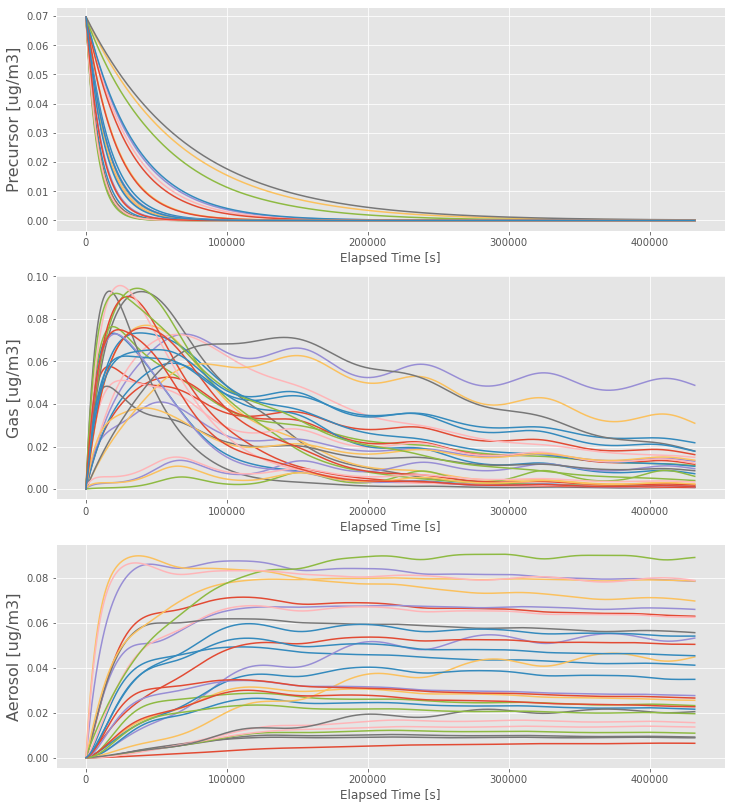

In [ ]:
# Spaghetti plot random experiment timeseries
num_expiriments = 30
exps = sorted(random.sample(list(train['id'].unique()), num_expiriments))
plot_df = train.loc[train['id'].isin(exps)].reset_index(drop=True)

fig, ax = plt.subplots(3,1, figsize=(12,14))
for i,lab in enumerate(['Precursor [ug/m3]', 'Gas [ug/m3]', 'Aerosol [ug/m3]']):
    for exp in exps:
        ax[i].plot(plot_df[plot_df['id'] == exp].iloc[:,0], plot_df[plot_df['id'] == exp].iloc[:,i+1])
    ax[i].set_xlabel('Elapsed Time [s]')
    ax[i].set_ylabel(lab, fontsize=16) 

## Data Preperation
Here we prepare the data for machine learning by taking the respective variables from each column, offsetting the output data by 1 timestep (this is done inside the `prepare_data()` function, and scale. Make sure to not re-fit the scaler on the validation/test data and only `transform()` it. 

In [ ]:
input_vars, output_vars = train.columns, train.columns[[0,1,2,3,-1]]
train_in, train_out = prepare_data(train, input_vars, output_vars)
val_in, val_out     = prepare_data(val, input_vars, output_vars)

input_scaler = MinMaxScaler()
output_scaler = MinMaxScaler()

scaled_train_in = input_scaler.fit_transform(train_in.iloc[:,1:-1])
scaled_train_out = output_scaler.fit_transform(train_out.iloc[:,1:-1])
scaled_val_in = input_scaler.transform(val_in.iloc[:,1:-1])
scaled_val_out = output_scaler.transform(val_out.iloc[:,1:-1])

In [ ]:
scaled_train_in.shape, scaled_train_out.shape, scaled_val_in.shape, scaled_val_out.shape,

((2015999, 9), (2015999, 3), (287999, 9), (287999, 3))

## Baseline Machine Learning Model
Here we use a pretty basic Dense Neural Network to predict the 3 output variables at the next timestep. We will then feed this into the Box Emulator model to run forward in time for n timesteps.

In [ ]:
%%time
tf.random.set_seed(seed)
mod = dense_neural_net()
history = mod.fit(scaled_train_in, scaled_train_out, validation_data=(scaled_val_in, scaled_val_out), 
                  batch_size=256, epochs=5, verbose=1)
mod.summary()

Train on 2015999 samples, validate on 287999 samples
Epoch 1/5
2015999/2015999 [==============================] - 15s 7us/sample - loss: 5.6171e-04 - val_loss: 2.9055e-04
Epoch 2/5
2015999/2015999 [==============================] - 14s 7us/sample - loss: 2.8920e-04 - val_loss: 2.7538e-04
Epoch 3/5
2015999/2015999 [==============================] - 15s 7us/sample - loss: 2.8657e-04 - val_loss: 2.7810e-04
Epoch 4/5
2015999/2015999 [==============================] - 14s 7us/sample - loss: 2.8463e-04 - val_loss: 2.8199e-04
Epoch 5/5
2015999/2015999 [==============================] - 15s 7us/sample - loss: 2.8369e-04 - val_loss: 2.7371e-04
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
dense (Dense)                (None, 100)               1000      
____________

## Box Emulator Model
This model (`box_emulator()`), takes one timestep of initial conditions to feed the neural network we built. It then predicts one timestep, and uses the prediction as the input for another prediction (along with the static environmental variables), and so forth for *n* timesteps. In actual practice, the environmental variables from the climate model would be varying as well, but we use a variety of experiments with variable enviromental factors to learn from and simplify the process. 

The `run_emulator_ensemble()` function takes *n* random experiments and runs the `box_emulator()` for the length of each experiment and returns the predictions as well as the corresponding truth values.\

We can then use the `evaluate_box_mod()` to return a variety of performance metrics.

NOTE: It takes ~40 seconds per experiment to run the box emulator.

In [ ]:
%%time
random.seed(seed)
num_exps = 5
pred_box, true_box = run_emulator_ensemble(val_in, mod, num_exps, input_vars, input_scaler, output_scaler)

CPU times: user 3min 33s, sys: 18.8 s, total: 3min 52s
Wall time: 3min 27s


## Evaluation

In [ ]:
# get predictions and truth
pred_nn = pd.DataFrame(output_scaler.inverse_transform(mod.predict(scaled_val_in))).iloc[1:,:]
true_val = val_out.iloc[:-1,1:4]

print('Metrics for base model:')
evaluate_mod(true_val, pred_nn)

Metrics for base model:
RMSE: Precursor: 0.00019, Gas: 0.00033, Aerosols: 0.00013
R2: Precursor: 0.99978, Gas: 0.99983, Aerosols: 0.99997
Hellenger Distance: Precursor: 0.00003, Gas: 0.00003, Aerosols: 0.00004


Metrics for Box Emulator:
RMSE: Precursor: 0.00946, Gas: 0.06098, Aerosols: 0.02118
R2: Precursor: 0.53770, Gas: 0.00260, Aerosols: 0.47804
Hellenger Distance: Precursor: 0.11655, Gas: 0.21057, Aerosols: 0.33689


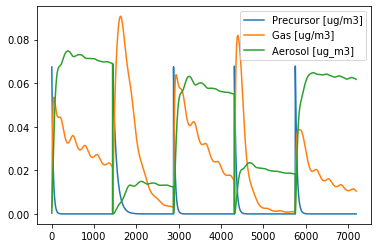

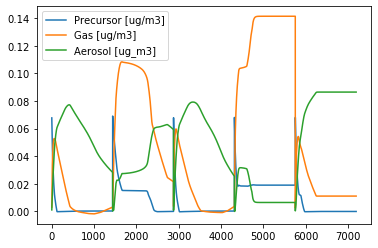

In [ ]:
print('Metrics for Box Emulator:')
evaluate_mod(true_box, pred_box)

## Quick plot to see if emulator is capturing the patterns
true_box.iloc[:,0:3].plot()
pred_box.iloc[:,0:3].plot()

As you can see, it is relatively easy to train the base network to predict t+1 values. It is far more challenging to model the length of the experiment (~1440 timesteps). Furthermore, you may discover that better performance on the neural network may not mean better performance with the box emulator. 

Some potential ideas for better emulator performance: adding some noise to the training data to prevent overfitting, or using a recurrent neural network/LSTM to utilize more than one timestep to inform prediction of the next. 

| Model Type | Metric | Variable |||
| ------------- | :----:|:-------:|:------:|:-----|
|  Baseline DNN|| Precursor | Gas | Aerosols |   
|              | RMSE: |**0.00019**|**0.00035**|**0.00014**|
|              | R2: |**0.99979**|**0.99984**|**0.99997**|
|              | Hellenger Distance: |**0.00002**|**0.00011**|**0.00004**|
|||||
|  Box Emulator|| Precursor | Gas | Aerosol |   
|              | RMSE: |**0.007**|**0.048**|**0.021**|
|              | R2: |**0.685**|**0.031**|**0.410**|
|              | Hellenger Distance: |**0.067**|**0.256**|**0.329**|

## Hackathon Challenges

### Monday
* Load the data
* Create an exploratory visualization of the data
* Test two different transformation and scaling methods
* Test one dimensionality reduction method
* Train a linear model
* Train a decision tree ensemble method of your choice

In [ ]:
# Monday's code goes here

# load data
fs = s3fs.S3FileSystem(anon=True)
gecko_files = fs.ls("ncar-aiml-data-commons/gecko/")[1:]
test, train, val = map(fetch_data, gecko_files)


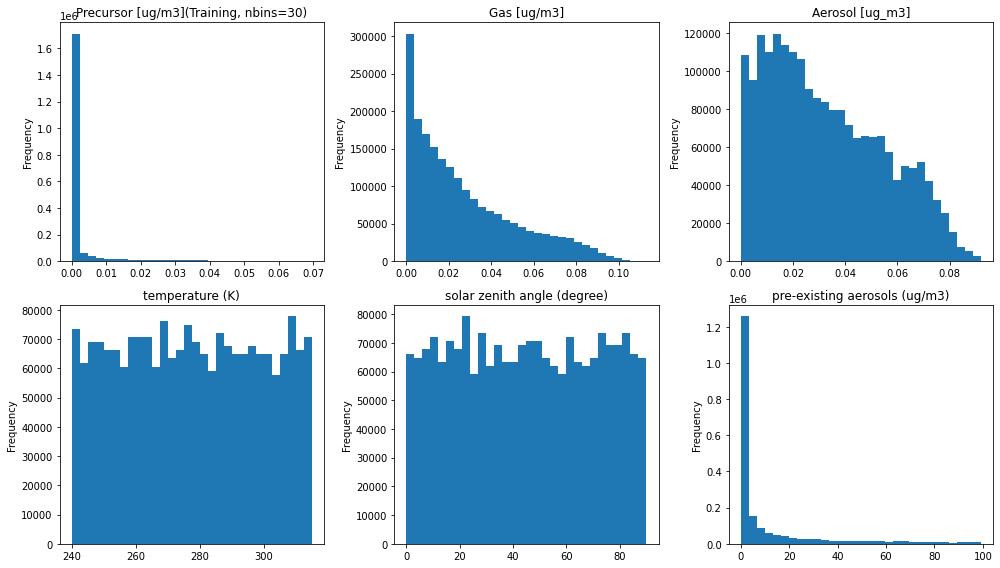

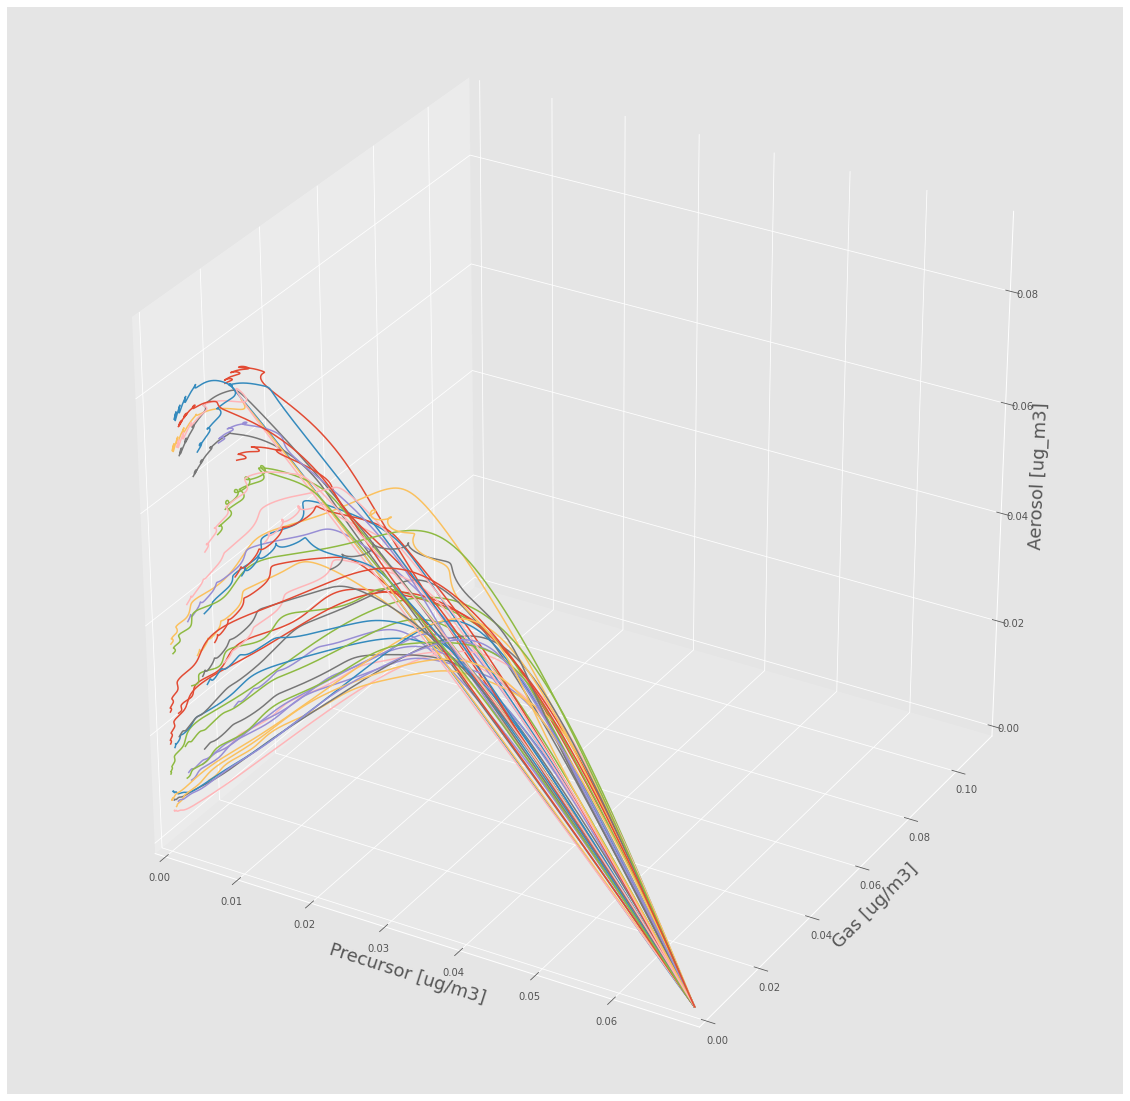

In [ ]:
# exploratory visualization

# Get dataframe keys
vnames = test.keys().to_list()
#  Histogram, Training Dataset
nbins = 30
num_experiments = 30
exps = sorted(random.sample(list(train["id"].unique()), num_experiments))
plot_df = train.copy()    
fig, axs = plt.subplots(2,3, figsize=(14,8))
v = 1
for i in range(2):
    for j in range(3):
        lab = vnames[v]
        # Get variable and label
        varplot = plot_df.iloc[:,v]
        # Plot the histogram
        varplot.plot.hist(bins=nbins,ax=axs[i,j])
        if v == 1:
            axs[i,j].set_title(lab+"(Training, nbins=%i)"%nbins,fontsize=12)
        else:
            axs[i,j].set_title(lab,fontsize=12)
        v += 1
plt.style.use('ggplot')
#plt.suptitle(“Histograms for All Training Experiments, nbins=%i” %nbins)
plt.tight_layout()

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
def vis3d(data,numexp):
  fig = plt.figure(figsize=(20,20))
  ax = fig.gca(projection="3d")
  exps = random.sample(list(data['id'].unique()), numexp)
  for i in range(len(exps)):
    x = data[data["id"]==exps[i]]["Precursor [ug/m3]"]
    y = data[data["id"]==exps[i]]["Gas [ug/m3]"]
    z = data[data["id"]==exps[i]]["Aerosol [ug_m3]"]
    ax.plot(x, y, z)
  ax.set_xlim(min(data["Precursor [ug/m3]"]), max(data["Precursor [ug/m3]"]))
  ax.set_ylim(min(data["Gas [ug/m3]"]), max(data["Gas [ug/m3]"]))
  ax.set_zlim(min(data["Aerosol [ug_m3]"]), max(data["Aerosol [ug_m3]"]))
  ax.set_xlabel('Precursor [ug/m3]', fontsize=18)
  ax.set_ylabel('Gas [ug/m3]', fontsize=18)
  ax.set_zlabel('Aerosol [ug_m3]', fontsize=18)
  return ax
vis3d(train, 50)

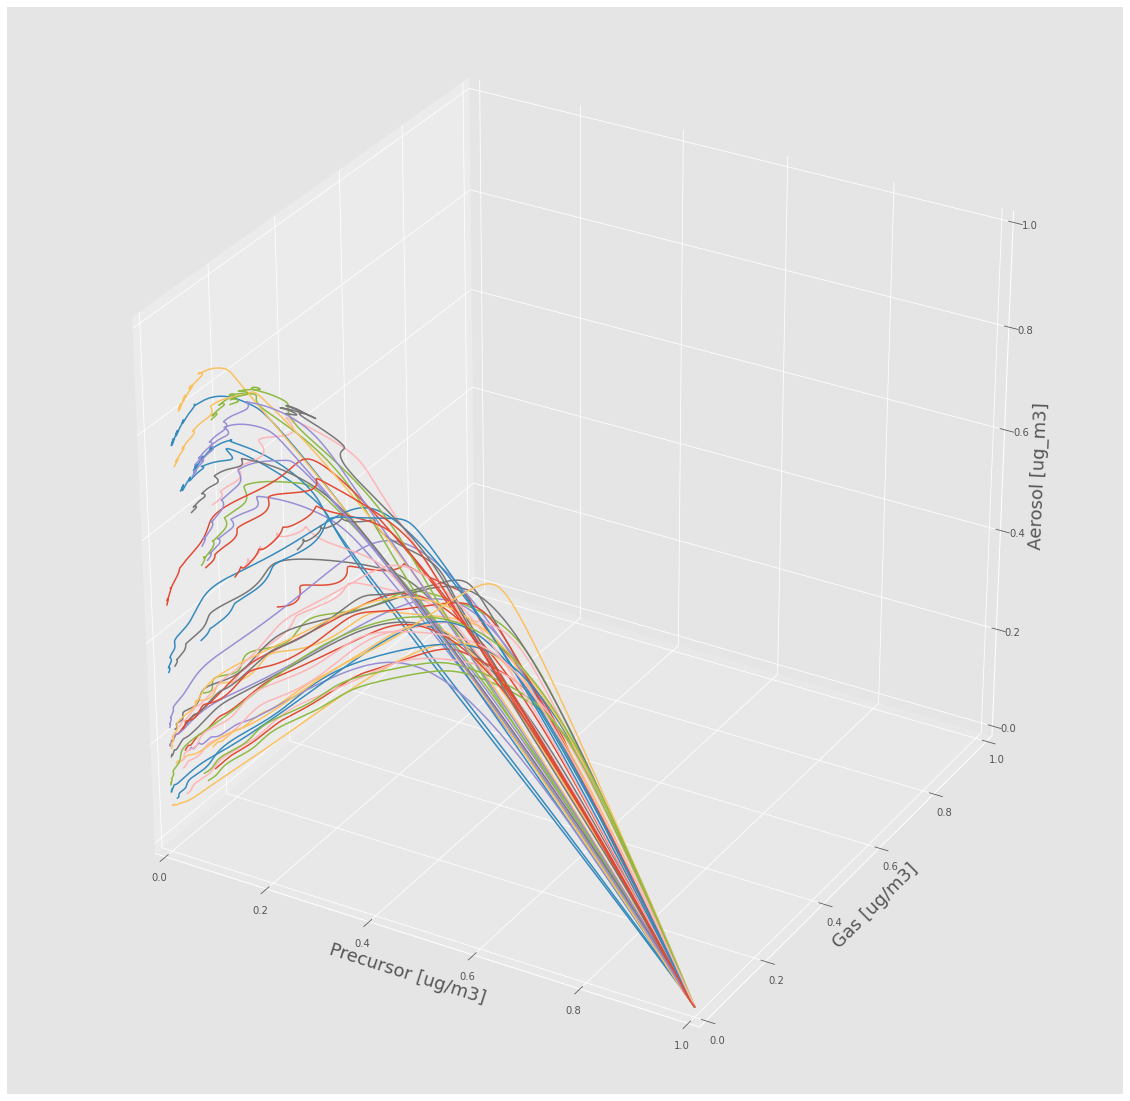

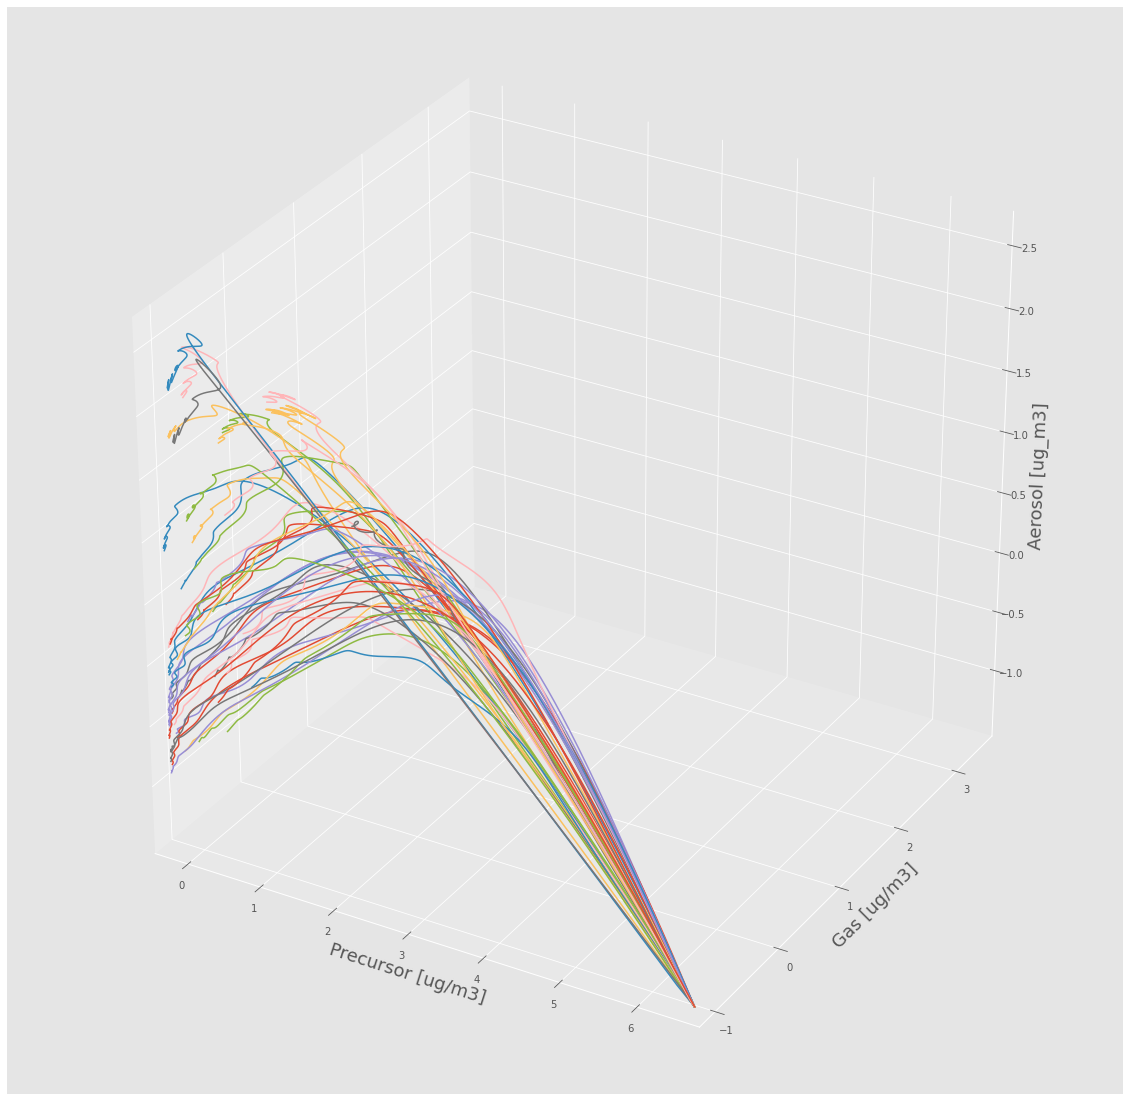

In [ ]:
# transformation and scaling
scaler1 = MinMaxScaler()
scaled_train_array = scaler1.fit_transform(train.loc[:,["Precursor [ug/m3]","Gas [ug/m3]", "Aerosol [ug_m3]"]])
scaled_train_array = np.concatenate((scaled_train_array, train.loc[:,["id"]]),axis=1)
scaled_train = pd.DataFrame({'Precursor [ug/m3]': scaled_train_array[:, 0],
                        'Gas [ug/m3]': scaled_train_array[:, 1],
                        'Aerosol [ug_m3]': scaled_train_array[:, 2],
                        'id': scaled_train_array[:, 3]})
vis3d(scaled_train, 50)

scaler2 = StandardScaler()
scaled_train_array = scaler2.fit_transform(train.loc[:,["Precursor [ug/m3]","Gas [ug/m3]", "Aerosol [ug_m3]"]])
scaled_train_array = np.concatenate((scaled_train_array, train.loc[:,["id"]]),axis=1)
scaled_train = pd.DataFrame({'Precursor [ug/m3]': scaled_train_array[:, 0],
                        'Gas [ug/m3]': scaled_train_array[:, 1],
                        'Aerosol [ug_m3]': scaled_train_array[:, 2],
                        'id': scaled_train_array[:, 3]})
vis3d(scaled_train, 50)

Text(0.5, 0, 'Relative Importance')

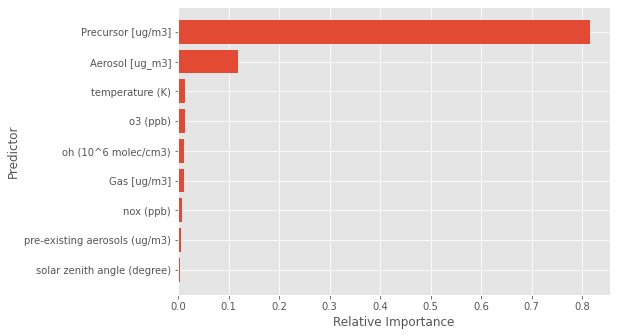

In [ ]:
# dimensionality reduction
input_vars, output_vars = train.columns, train.columns[[0,1,2,3,-1]]
train_in, train_out = prepare_data(train, input_vars, output_vars)
val_in, val_out = prepare_data(val, input_vars, output_vars)

input_scaler = MinMaxScaler()
output_scaler = MinMaxScaler()

scaled_train_in = input_scaler.fit_transform(train_in.iloc[:,1:-1])
scaled_train_out = output_scaler.fit_transform(train_out.iloc[:,1:-1])
scaled_val_in = input_scaler.transform(val_in.iloc[:,1:-1])
scaled_val_out = output_scaler.transform(val_out.iloc[:,1:-1])

from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state=1, max_depth=5)
sample = random.sample(range(scaled_train_in.shape[0]), 100) # had to take a random sample for reasonable computational time
model.fit(scaled_train_in[sample,:],scaled_train_out[sample,0])

features = ["Precursor [ug/m3]",	"Gas [ug/m3]",	"Aerosol [ug_m3]",	"temperature (K)",
            "solar zenith angle (degree)",	"pre-existing aerosols (ug/m3)",
            "o3 (ppb)",	"nox (ppb)",	"oh (10^6 molec/cm3)"]
importances = model.feature_importances_
indices = np.argsort(importances)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
features_sort = [features[i] for i in indices]
importances_sort = importances[indices]
ax.barh(features_sort,importances_sort)
ax.set_ylabel('Predictor')
ax.set_xlabel('Relative Importance')

RMSE: Precursor: 0.02455, Gas: 0.00173, Aerosols: 0.00915
R2: Precursor: 0.96975, Gas: 0.99993, Aerosols: 0.99851
Hellenger Distance: Precursor: 0.00039, Gas: 0.00013, Aerosols: 0.00007


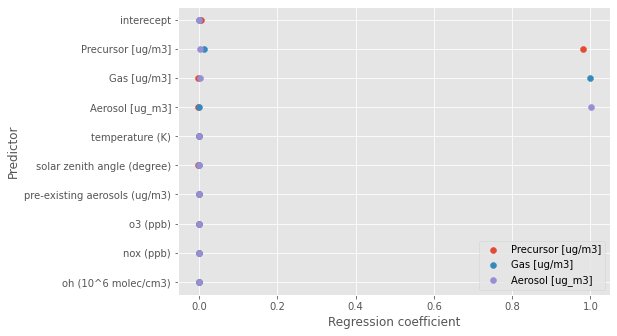

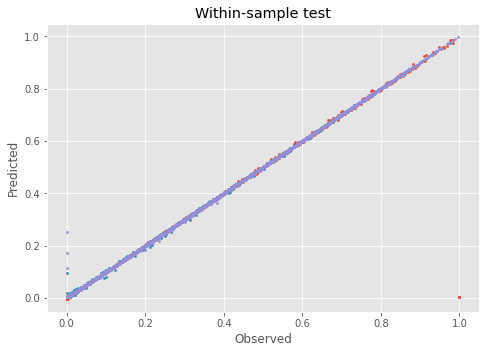

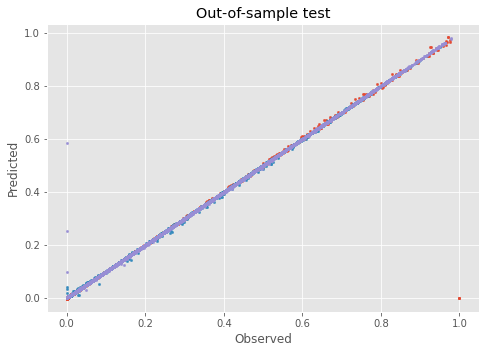

In [ ]:
# linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression() 
sample_train = random.sample(range(scaled_train_in.shape[0]), 5000)
sample_val =    random.sample(range(scaled_val_in.shape[0]), 5000)
# features_select = [features[i] for i in indices[::-1] ][0:5]
# model.fit(scaled_train_in[sample,:][:,indices[::-1][0:5]],scaled_train_out[sample,0])
model.fit(scaled_train_in[sample_train,:],scaled_train_out[sample_train,])

estimates=[]
for i in range(3):
  estimates.append( np.append(model.intercept_[i],model.coef_[i]))
coef_df = pd.DataFrame({'Predictor': ['interecept']+features,
                        'Precursor [ug/m3]': estimates[0],
                        'Gas [ug/m3]': estimates[1],
                        'Aerosol [ug_m3]': estimates[2]})
minval=min(np.concatenate(estimates))
maxval=max(np.concatenate(estimates))

fig = plt.figure()
ax = fig.add_axes([minval,0,maxval,1])
for response in ["Precursor [ug/m3]", "Gas [ug/m3]",	"Aerosol [ug_m3]"]:
  ax.scatter(coef_df[response],coef_df["Predictor"], label=response)
ax.invert_yaxis()
ax.legend(numpoints=1, loc='lower right')
ax.set_ylabel('Predictor')
ax.set_xlabel('Regression coefficient')

scaled_train_pred = model.predict(scaled_train_in[sample_train,:])
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
for i in range(3):
  ax.scatter(scaled_train_out[sample_train,i], scaled_train_pred[:,i], s=5)
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')
ax.set_title("Within-sample test")

scaled_val_pred = model.predict(scaled_val_in[sample_val,:])
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
for i in range(3):
  ax.scatter(scaled_val_out[sample_val,i], scaled_val_pred[:,i], s=5)
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')
ax.set_title("Out-of-sample test")

scaled_val_out_df=pd.DataFrame(scaled_val_out[sample_val,:])
scaled_val_pred_df=pd.DataFrame(scaled_val_pred)
evaluate_mod(scaled_val_out_df, scaled_val_pred_df)


RMSE: Precursor: 0.02452, Gas: 0.00354, Aerosols: 0.00921
R2: Precursor: 0.96772, Gas: 0.99974, Aerosols: 0.99845
Hellenger Distance: Precursor: 0.00075, Gas: 0.00090, Aerosols: 0.00024


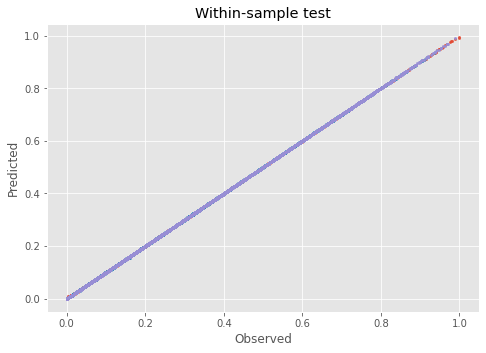

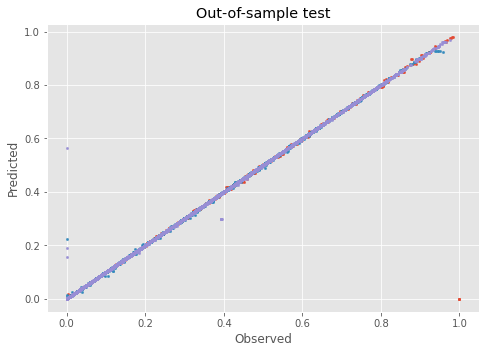

In [ ]:
# decision tree ensemble (gradient boosting)
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(random_state=1, max_depth=5) 
sample_train = random.sample(range(scaled_train_in.shape[0]), 5000)
sample_val = random.sample(range(scaled_val_in.shape[0]), 5000)

for i in range(3):
  model.fit(scaled_train_in[sample_train,:],scaled_train_out[sample_train,i])
  scaled_train_pred[:,i] = model.predict(scaled_train_in[sample_train,:])
  scaled_val_pred[:,i] = model.predict(scaled_val_in[sample_val,:])

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
for i in range(3):
  ax.scatter(scaled_train_out[sample_train,i], scaled_train_pred[:,i], s=5)
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')
ax.set_title("Within-sample test")

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
for i in range(3):
  ax.scatter(scaled_val_out[sample_val,i], scaled_val_pred[:,i], s=5)
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')
ax.set_title("Out-of-sample test")

scaled_val_out_df=pd.DataFrame(scaled_val_out[sample_val,:])
scaled_val_pred_df=pd.DataFrame(scaled_val_pred)
evaluate_mod(scaled_val_out_df, scaled_val_pred_df)

### Tuesday
* Train a densely connected neural network
* Train a convolutional or recurrent neural network (depends on problem)
* Experiment with different architectures

In [ ]:
# Tuesday's code goes here


# The data was preprocessed in the code above. The following data is available:

# Training Data Inputs; Training Data Outputs; Validation Inputs, Validation Outputs
scaled_train_in.shape, scaled_train_out.shape, scaled_val_in.shape, scaled_val_out.shape,

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        5.88150060e-01, 1.86033313e-01, 3.61322727e-01],
       [9.83262972e-01, 1.79342531e-02, 2.87506197e-07, ...,
        5.88150060e-01, 1.86033313e-01, 3.61322727e-01],
       [9.66805570e-01, 3.58101714e-02, 8.53601204e-07, ...,
        5.88150060e-01, 1.86033313e-01, 3.61322727e-01],
       ...,
       [6.50875261e-15, 7.04544901e-03, 1.00475456e-01, ...,
        8.33476914e-01, 3.30366946e-01, 5.26053556e-01],
       [6.36236459e-15, 7.01483562e-03, 1.00456576e-01, ...,
        8.33476914e-01, 3.30366946e-01, 5.26053556e-01],
       [6.21926954e-15, 6.98427934e-03, 1.00437695e-01, ...,
        8.33476914e-01, 3.30366946e-01, 5.26053556e-01]])

In [ ]:
# From code above, train a simple DNN model, that predicts values at t = t+1
# Used different specifications (1 layer instead of 2; 250 neurons instead of 100)

def dense_neural_net(num_layers=2, num_neurons=100, activation="relu", learning_rate=0.001,
                     num_input_columns=9, num_output_columns=3):
    """ Build and return dense neural network with specified hyperparameters"""
    
    input_layer = Input(num_input_columns)
    n_net = input_layer
    for l in range(num_layers):
        n_net= Dense(num_neurons, activation=activation)(n_net)
        
    
    out = Dense(num_output_columns)(n_net)
    mod = Model(input_layer, out)
    
    # Edited to try SGD instead of Adam
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    mod.compile(opt, "mse")
    
    return mod

#%%time

# Initiate random tensor/seed
tf.random.set_seed(seed)

# Define and Compile DNN Model, using defaults specified in function above
# This time, I used only 1 layer, but x2.5 number of neurons
mod = dense_neural_net(num_layers=1,num_neurons=250)

# Fit the model to the data
history = mod.fit(scaled_train_in, scaled_train_out, validation_data=(scaled_val_in, scaled_val_out), 
                  batch_size=256, epochs=5, verbose=1)

# Summarize everything
mod.summary()

Epoch 1/5
7875/7875 [==============================] - 15s 2ms/step - loss: 0.0272 - val_loss: 0.0125
Epoch 2/5
7875/7875 [==============================] - 15s 2ms/step - loss: 0.0085 - val_loss: 0.0059
Epoch 3/5
7875/7875 [==============================] - 15s 2ms/step - loss: 0.0046 - val_loss: 0.0037
Epoch 4/5
7875/7875 [==============================] - 15s 2ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 5/5
7875/7875 [==============================] - 15s 2ms/step - loss: 0.0022 - val_loss: 0.0019
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 9)]               0         
_________________________________________________________________
dense_81 (Dense)             (None, 250)               2500      
_________________________________________________________________
dense_82 (Dense)             (None, 3)                 753       
Total param

In [ ]:
# Feed model in the ensemble box model runner (same as above, just pasted here for reference)

def box_emulator(neural_network, starting_conds, input_scaler, output_scaler, num_timesteps=1439):
    """ Forward box emulator
    Args:
        neural_netwrok: NN model object that predits output at t+1
        starting_conds: Initial input conditions used for first prediction
        input_scaler: Input scaler object
        onput_scaler: Onput scaler object
        num_timesteps: how many timesteps forward to run emulator
    Returns:
        results: Pandas DataFrame of box emulator output
    """
    mod = neural_network
    scaled_input = input_scaler.transform(starting_conds.iloc[:,1:-1])
    static_input = scaled_input[:,-6:]

    for i in range(num_timesteps):

        if i == 0:

            pred = mod.predict(scaled_input)
            new_input = np.concatenate([pred,static_input], axis=1)
            pred_array = pred

        else:

            pred = mod.predict(new_input)
            new_input = np.concatenate([pred,static_input], axis=1)
            pred_array = np.concatenate([pred_array, pred], axis=0)
            
    results = pd.DataFrame(output_scaler.inverse_transform(pred_array))
    results['id'] = starting_conds.iloc[0,-1]
    results.columns = starting_conds.columns[[1,2,3,-1]]
    return results

def run_emulator_ensemble(input_data, mod, num_expiriments, input_vars, input_scaler, 
                          output_scaler, run_length=1439):
    """ Run an ensemble of emulators on n amount of random expiriments
    Args:
        input_data: unscaled dataframe collection of expiriment data
        mod: NN model object that predits output at t+1
        num_expiriments: How many expiriments to run
        input_vars: Input variables for model
        output_vars: Output variables for model
        run_length: number of timesteps to run each emulator forward
    Returns:
        pred_df: Aggregated Pandas DataFrame of predictions for each expiriment
        true_df: Corresponding Dataframe with raw expiriment data
    """
    output_cols = input_data.columns[[1,2,3, -1]]
    exps = sorted(random.sample(list(input_data['id'].unique()), num_expiriments))
    pred_df  = pd.DataFrame(columns = output_cols)
    true_df = input_data.loc[input_data['id'].isin(exps)][output_cols].reset_index(drop=True)
    true_df =  true_df.groupby('id').apply(lambda x: x.iloc[1:,:]).reset_index(drop=True)  
    
    for i in range(num_expiriments):
        
        init_conds = get_starting_conds(input_data, input_vars, exps[i])
        preds = box_emulator(mod, init_conds, input_scaler, output_scaler, run_length)
        preds['id'] = exps[i]
        preds.columns = pred_df.columns
        pred_df = pred_df.append(preds, ignore_index=True)

    return pred_df, true_df
#%%time
random.seed(seed)
num_exps = 5
pred_box, true_box = run_emulator_ensemble(val_in, mod, num_exps, input_vars, input_scaler, output_scaler)

Metrics for base model:
RMSE: Precursor: 0.00386, Gas: 0.00335, Aerosols: 0.00325
R2: Precursor: 0.92760, Gas: 0.98337, Aerosols: 0.97870
Hellenger Distance: Precursor: 0.16916, Gas: 0.01050, Aerosols: 0.03088
Metrics for Box Emulator:
RMSE: Precursor: 0.00902, Gas: 0.03239, Aerosols: 0.01123
R2: Precursor: 0.05871, Gas: 0.00009, Aerosols: 0.85172
Hellenger Distance: Precursor: 0.71615, Gas: 0.60664, Aerosols: 0.48227


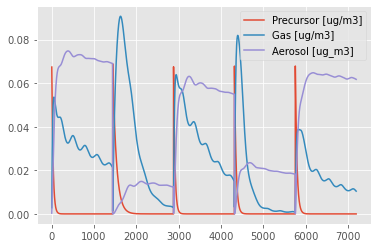

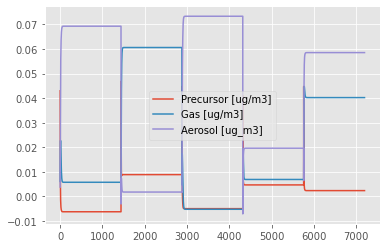

In [ ]:
# Evaluate Model

# get predictions and truth
pred_nn = pd.DataFrame(output_scaler.inverse_transform(mod.predict(scaled_val_in))).iloc[1:,:]
true_val = val_out.iloc[:-1,1:4]

print('Metrics for base model:')
evaluate_mod(true_val, pred_nn)

print('Metrics for Box Emulator:')
evaluate_mod(true_box, pred_box)

## Quick plot to see if emulator is capturing the patterns
true_box.iloc[:,0:3].plot()
pred_box.iloc[:,0:3].plot()



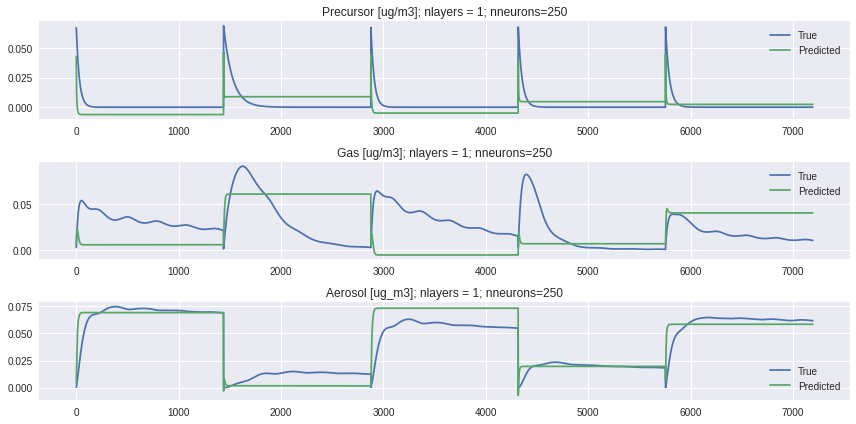

In [ ]:
# Split plots by variable to compare
fig,axs = plt.subplots(3,1,figsize=(12,6))

for i in range(3):
    lab = vnames[i+1]
    
    plt.subplot(3,1,i+1)
    
    plt.plot(true_box.iloc[:,i],label="True")
    plt.plot(pred_box.iloc[:,i],label="Predicted")
    plt.title(lab+"; nlayers = 1; nneurons=250")
    plt.legend()
#plt.suptitle('Box Model Results: nlayers = 1; nneurons=250')
plt.tight_layout()
plt.style.use('seaborn')



In [3]:
# We noticed some issues in the prepare_data function provided, so we modified it and fit the DNN again
# dense neural network
def prepare_data_new(data, input_columns, output_columns):
    """ Splits data to input/output with corresponding lag """
    
    data['id'] = data['id'].apply(lambda x: int(x[3:])) # change expnumber to int for sorting
    data.index.name = 'indx'
    data = data.sort_values(['id','indx'])
    exps = list(data['id'].unique())
    x_data_list=[None]*len(exps)
    y_data_list=[None]*len(exps)
    for exp in range(len(exps)): # added loop
      data_subset=data[data['id']==exps[exp]]
      x_data_list[exp] = data_subset[input_columns].iloc[:-1, :]
      y_data_list[exp] = data_subset[output_columns].iloc[1:, :]
    x_data = pd.concat(x_data_list)
    y_data = pd.concat(y_data_list)
    return x_data, y_data

# load data
fs = s3fs.S3FileSystem(anon=True)
gecko_files = fs.ls("ncar-aiml-data-commons/gecko/")[1:]
test, train, val = map(fetch_data, gecko_files)

# preprocess data
input_vars, output_vars = train.columns[1:-1], train.columns[[1,2,3]]
scaler = MinMaxScaler()
scaled_train_array = scaler.fit_transform(train.iloc[:,1:-1])
scaled_val_array = scaler.transform(val.iloc[:,1:-1])
scaler_out = MinMaxScaler()
scaler_out.min_, scaler_out.scale_= scaler.min_[0:3],scaler.scale_[0:3]

scaled_train=train.copy()
scaled_train[input_vars]=scaled_train_array
scaled_val=val.copy()
scaled_val[input_vars]=scaled_val_array

scaled_train_in, scaled_train_out = prepare_data_new(scaled_train, input_vars, output_vars)
scaled_val_in, scaled_val_out = prepare_data_new(scaled_val, input_vars, output_vars)

# dense neural network
def dense_neural_net(num_layers=2, num_neurons=100, activation="relu", learning_rate=0.001,
                     num_input_columns=9, num_output_columns=3):
    """ Build and return dense neural network with specified hyperparameters"""
    
    input_layer = Input(num_input_columns)
    n_net = input_layer
    for l in range(num_layers):
        n_net= Dense(num_neurons, activation=activation)(n_net)
    out = Dense(num_output_columns)(n_net)
    mod = Model(input_layer, out)
    mod.compile(Adam(learning_rate=learning_rate), "mse")
    
    return mod

# %%time
tf.random.set_seed(seed)
mod = dense_neural_net()
history = mod.fit(scaled_train_in, scaled_train_out, validation_data=(scaled_val_in, scaled_val_out), 
                  batch_size=256, epochs=5, verbose=1)
mod.summary()

# get predictions and truth
pred_nn = pd.DataFrame(scaler_out.inverse_transform(mod.predict(scaled_val_in)))
true_val = pd.DataFrame(scaler_out.inverse_transform(scaled_val_out))
print('Metrics for base model:')
evaluate_mod(true_val, pred_nn)

# %%time
random.seed(seed)
num_exps = 5
pred_box, true_box = run_emulator_ensemble(val, mod, num_exps, input_vars, scaler, scaler_out)

print('Metrics for Box Emulator:')
evaluate_mod(true_box, pred_box)

## Quick plot to see if emulator is capturing the patterns
true_box.iloc[:,0:3].plot()
pred_box.iloc[:,0:3].plot()

# Split plots by variable to compare
fig,axs = plt.subplots(3,1,figsize=(12,6))

for i in range(3):
    lab = vnames[i+1]
    
    plt.subplot(3,1,i+1)
    
    plt.plot(true_box.iloc[:,i],label="True")
    plt.plot(pred_box.iloc[:,i],label="Predicted")
    plt.title(lab+"; nlayers = 2; nneurons=100")
    plt.legend()
plt.tight_layout()
plt.style.use('seaborn')

Epoch 1/5
6373/7870 [=======================>......] - ETA: 3s - loss: 3.3454e-04

KeyboardInterrupt: ignored

In [4]:
# change some functions to prepare for time series analysis
def prepare_data_ts(data, input_columns, output_columns, lags=1):
    """ Splits data to input/output with corresponding lag """
    
    data['id'] = data['id'].apply(lambda x: int(x[3:])) # change expnumber to int for sorting
    data.index.name = 'indx'
    data = data.sort_values(['id','indx'])
    exps = list(data['id'].unique())

    x_data=np.empty(shape=(0,lags,len(input_columns)),dtype='float64') 
    y_data=np.empty(shape=(0,len(output_columns)),dtype='float64') 
    for exp in range(len(exps)):
      data_subset=data[data['id']==exps[exp]]
      x_data_subset=np.empty(shape=((data_subset.shape[0]-lags),lags,len(input_columns)),dtype='float64') 
      y_data_subset=np.empty(shape=((data_subset.shape[0]-lags),len(output_columns)),dtype='float64') 

      y_data_subset[:,:] = data_subset[output_columns].iloc[lags:, :]
      y_data = np.concatenate([y_data,y_data_subset])
      for lag in range(lags):
        x_data_subset[:,lag,:] = data_subset[input_columns].iloc[lag:(data_subset.shape[0]-lags+lag), :]
      x_data = np.concatenate([x_data,x_data_subset])

    return x_data, y_data

def get_starting_conds_ts(data, input_vars, exp, lags, starting_ts=0):
    """ Take data and expiriment number to gather initial starting condition for box emulator"""
    exp_data = data[data['id'] == exp]
    
    if exp_data.shape[0] == 0:
        raise ValueError('That expiriment number does not exist in this dataset.')
    
    ts_data = exp_data.iloc[starting_ts:(starting_ts+lags), :]

    return ts_data

def box_emulator_ts(neural_network, starting_conds, input_scaler, output_scaler, num_timesteps, lags):
    """ Forward box emulator
    Args:
        neural_netwrok: NN model object that predits output at t+1
        starting_conds: Initial input conditions used for first prediction
        input_scaler: Input scaler object
        onput_scaler: Onput scaler object
        num_timesteps: how many timesteps forward to run emulator
    Returns:
        results: Pandas DataFrame of box emulator output
    """
    mod = neural_network
    scaled_input = input_scaler.transform(starting_conds.iloc[:,1:-1])
    scaled_input = np.expand_dims(scaled_input, axis=0)
    static_input = scaled_input[:,:,-6:]

    for i in range(num_timesteps):

        if i == 0:
            pred = mod.predict(scaled_input)
            dynamic_input = np.concatenate([scaled_input[:,1:lags,0:3],np.expand_dims(pred, axis=0)], axis=1)
            new_input = np.concatenate([dynamic_input,static_input], axis=2)
            pred_array = pred

        else:
            pred = mod.predict(new_input)
            dynamic_input = np.concatenate([new_input[:,1:lags,0:3],np.expand_dims(pred, axis=0)], axis=1)
            new_input = np.concatenate([dynamic_input,static_input], axis=2)
            pred_array = np.concatenate([pred_array, pred], axis=0)
            
    results = pd.DataFrame(output_scaler.inverse_transform(pred_array))
    results['id'] = starting_conds.iloc[0,-1]
    results.columns = starting_conds.columns[[1,2,3,-1]]
    return results

def run_emulator_ensemble_ts(input_data, mod, num_expiriments, input_vars, input_scaler, 
                          output_scaler, run_length=1440-1, lags=1):
    """ Run an ensemble of emulators on n amount of random expiriments
    Args:
        input_data: unscaled dataframe collection of expiriment data
        mod: NN model object that predits output at t+1
        num_expiriments: How many expiriments to run
        input_vars: Input variables for model
        output_vars: Output variables for model
        run_length: number of timesteps to run each emulator forward
    Returns:
        pred_df: Aggregated Pandas DataFrame of predictions for each expiriment
        true_df: Corresponding Dataframe with raw expiriment data
    """
    output_cols = input_data.columns[[1,2,3, -1]]
    exps = sorted(random.sample(list(input_data['id'].unique()), num_expiriments))
    pred_df  = pd.DataFrame(columns = output_cols)
    true_df = input_data.loc[input_data['id'].isin(exps)][output_cols].reset_index(drop=True)
    true_df =  true_df.groupby('id').apply(lambda x: x.iloc[lags:,:]).reset_index(drop=True)  
    
    for i in range(num_expiriments):
        
        init_conds = get_starting_conds_ts(input_data, input_vars, exps[i],lags)
        preds = box_emulator_ts(mod, init_conds, input_scaler, output_scaler, run_length, lags)
        # preds['id'] = exps[i]
        preds.columns = pred_df.columns
        pred_df = pred_df.append(preds, ignore_index=True)

    return pred_df, true_df

In [35]:
# prepare time series data
# load data
fs = s3fs.S3FileSystem(anon=True)
gecko_files = fs.ls("ncar-aiml-data-commons/gecko/")[1:]
test, train, val = map(fetch_data, gecko_files)

# preprocess data
input_vars, output_vars = train.columns[1:-1], train.columns[[1,2,3]]
scaler = MinMaxScaler()
scaled_train_array = scaler.fit_transform(train.iloc[:,1:-1])
scaled_val_array = scaler.transform(val.iloc[:,1:-1])
scaler_out = MinMaxScaler()
scaler_out.min_, scaler_out.scale_= scaler.min_[0:3],scaler.scale_[0:3]

scaled_train=train.copy()
scaled_train[input_vars]=scaled_train_array
scaled_val=val.copy()
scaled_val[input_vars]=scaled_val_array

numlags=5
scaled_train_in, scaled_train_out = prepare_data_ts(scaled_train, input_vars, output_vars, lags=numlags)
scaled_val_in, scaled_val_out = prepare_data_ts(scaled_val, input_vars, output_vars, lags=numlags)
# scaled_val_in[:,:,0:1] # checking

In [ ]:
def prepare_data_ts(data, input_columns, output_columns, lags=1):
    """ Splits data to input/output with corresponding lag """
    
    data['id'] = data['id'].apply(lambda x: int(x[3:])) # change expnumber to int for sorting
    data.index.name = 'indx'
    data = data.sort_values(['id','indx'])
    exps = list(data['id'].unique())

    x_data=np.empty(shape=(0,lags,len(input_columns)),dtype='float64') 
    y_data=np.empty(shape=(0,len(output_columns)),dtype='float64') 
    for exp in range(len(exps)):
      data_subset=data[data['id']==exps[exp]]
      x_data_subset=np.empty(shape=((data_subset.shape[0]-lags),lags,len(input_columns)),dtype='float64') 
      y_data_subset=np.empty(shape=((data_subset.shape[0]-lags),len(output_columns)),dtype='float64') 

      y_data_subset[:,:] = data_subset[output_columns].iloc[lags:, :]
      y_data = np.concatenate([y_data,y_data_subset])
      for lag in range(lags):
        x_data_subset[:,lag,:] = data_subset[input_columns].iloc[lag:(data_subset.shape[0]-lags+lag), :]
      x_data = np.concatenate([x_data,x_data_subset])

    return x_data, y_data

In [6]:
# other neural network (simple RNN)
# recurrent neural network
from tensorflow.keras.layers import SimpleRNN,LSTM,Conv1D, MaxPooling2D, Flatten

def rec_neural_net(lags=numlags, num_layers=2, num_neurons=100, activation="relu", learning_rate=0.001,
                     num_input_columns=9, num_output_columns=3, option=["RNN","LSTM"]):
    """ Build and return recurrent neural network with specified hyperparameters"""
    
    input_layer = Input(shape=[lags,num_input_columns])
    n_net = input_layer
    if option == "RNN":
      for l in range(num_layers):
        n_net= SimpleRNN(num_neurons, activation=activation, return_sequences=True)(n_net)
      out = SimpleRNN(num_output_columns)(n_net)
    if option == "LSTM":
      for l in range(num_layers):
        n_net= LSTM(num_neurons, activation=activation, return_sequences=True)(n_net)
      out = LSTM(num_output_columns)(n_net)
    # if option == "CNN":
    #   for l in range(num_layers):
    #     n_net = Conv1D(num_neurons, 3, activation=activation,padding="SAME")(n_net)
    #     # n_net = MaxPooling2D((2,2), padding="SAME")(n_net)
    #   out = Conv1D(num_output_columns, 3,padding="SAME")(n_net)
    # out = Flatten()(out)
    mod = Model(input_layer, out)
    mod.compile(Adam(learning_rate=learning_rate), "mse")
    
    return mod
  
# # %%time
# tf.random.set_seed(seed)
# mod = rec_neural_net(option="RNN", lags=numlags, num_layers=2, num_neurons=100) #setting lags to 3 due to high computational cost
# history = mod.fit(scaled_train_in, scaled_train_out, validation_data=(scaled_val_in, scaled_val_out), 
#                   batch_size=256, epochs=5, verbose=1)
# mod.summary()

# # get predictions and truth
# pred_nn = pd.DataFrame(scaler_out.inverse_transform(mod.predict(scaled_val_in)))
# true_val = pd.DataFrame(scaler_out.inverse_transform(scaled_val_out))
# print('Metrics for base model:')
# evaluate_mod(true_val, pred_nn)

# # %%time
# random.seed(seed)
# num_exps = 5
# pred_box, true_box = run_emulator_ensemble_ts(val, mod, num_exps, input_vars, scaler, scaler_out, run_length=1440-numlags, lags=numlags)

# print('Metrics for Box Emulator:')
# evaluate_mod(true_box, pred_box)

# ## Quick plot to see if emulator is capturing the patterns
# true_box.iloc[:,0:3].plot()
# pred_box.iloc[:,0:3].plot()

# # Split plots by variable to compare
# fig,axs = plt.subplots(3,1,figsize=(12,6))

# for i in range(3):
#     lab = vnames[i+1]
    
#     plt.subplot(3,1,i+1)
    
#     plt.plot(true_box.iloc[:,i],label="True")
#     plt.plot(pred_box.iloc[:,i],label="Predicted")
#     plt.title(lab+"; nlayers = 2; nneurons=100")
#     plt.legend()
# plt.tight_layout()
# plt.style.use('seaborn')

Epoch 1/5
7848/7848 [==============================] - 378s 48ms/step - loss: 3.3162e-04 - val_loss: 2.6293e-06
Epoch 2/5
7848/7848 [==============================] - 380s 48ms/step - loss: 3.1661e-06 - val_loss: 1.8889e-06
Epoch 3/5
7848/7848 [==============================] - 378s 48ms/step - loss: 2.3072e-06 - val_loss: 2.7318e-06
Epoch 4/5
7848/7848 [==============================] - 372s 47ms/step - loss: 1.8513e-06 - val_loss: 2.1639e-06
Epoch 5/5
7848/7848 [==============================] - 373s 48ms/step - loss: 1.5643e-06 - val_loss: 6.4071e-07
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 5, 9)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 5, 100)            44000     
_________________________________________________________________
lstm_1 (LSTM)              

NameError: ignored

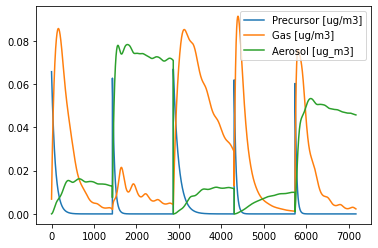

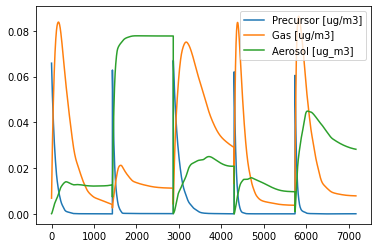

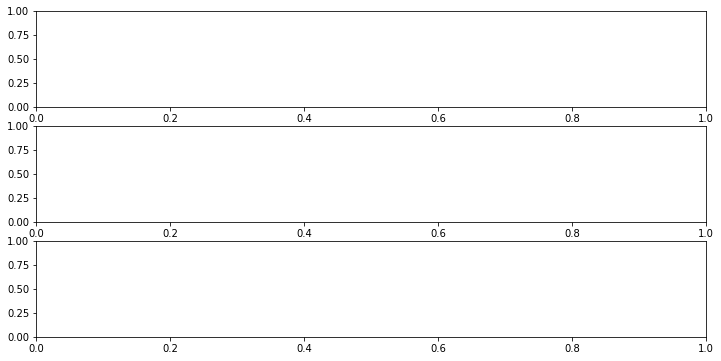

In [7]:
# other neural networks (LSTM)
# %%time
tf.random.set_seed(seed)
mod = rec_neural_net(option="LSTM", lags=numlags, num_layers=2, num_neurons=100) #setting lags to 3 due to high computational cost
history = mod.fit(scaled_train_in, scaled_train_out, validation_data=(scaled_val_in, scaled_val_out), 
                  batch_size=256, epochs=5, verbose=1)
mod.summary()

# get predictions and truth
pred_nn = pd.DataFrame(scaler_out.inverse_transform(mod.predict(scaled_val_in)))
true_val = pd.DataFrame(scaler_out.inverse_transform(scaled_val_out))
print('Metrics for base model:')
evaluate_mod(true_val, pred_nn)

# %%time
random.seed(seed)
num_exps = 5
pred_box, true_box = run_emulator_ensemble_ts(val, mod, num_exps, input_vars, scaler, scaler_out, run_length=1440-numlags, lags=numlags)

print('Metrics for Box Emulator:')
evaluate_mod(true_box, pred_box)

## Quick plot to see if emulator is capturing the patterns
true_box.iloc[:,0:3].plot()
pred_box.iloc[:,0:3].plot()

# Split plots by variable to compare
fig,axs = plt.subplots(3,1,figsize=(12,6))

for i in range(3):
    lab = vnames[i+1]
    
    plt.subplot(3,1,i+1)
    
    plt.plot(true_box.iloc[:,i],label="True")
    plt.plot(pred_box.iloc[:,i],label="Predicted")
    plt.title(lab+"; nlayers = 2; nneurons=100")
    plt.legend()
plt.tight_layout()
plt.style.use('seaborn')

In [19]:
mod.summary()
scaled_val_in

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 5, 9)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 5, 100)            44000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 100)            80400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 3)                 1248      
Total params: 125,648
Trainable params: 125,648
Non-trainable params: 0
_________________________________________________________________


array([[[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         6.51438224e-01, 4.14325193e-03, 8.28648520e-01],
        [9.66998352e-01, 2.52147019e-02, 3.81349886e-03, ...,
         6.51438224e-01, 4.14325193e-03, 8.28648520e-01],
        [9.35120399e-01, 5.21786087e-02, 9.65059612e-03, ...,
         6.51438224e-01, 4.14325193e-03, 8.28648520e-01],
        [9.04292746e-01, 7.78200348e-02, 1.58195564e-02, ...,
         6.51438224e-01, 4.14325193e-03, 8.28648520e-01],
        [8.74480965e-01, 1.02191295e-01, 2.22854583e-02, ...,
         6.51438224e-01, 4.14325193e-03, 8.28648520e-01]],

       [[9.66998352e-01, 2.52147019e-02, 3.81349886e-03, ...,
         6.51438224e-01, 4.14325193e-03, 8.28648520e-01],
        [9.35120399e-01, 5.21786087e-02, 9.65059612e-03, ...,
         6.51438224e-01, 4.14325193e-03, 8.28648520e-01],
        [9.04292746e-01, 7.78200348e-02, 1.58195564e-02, ...,
         6.51438224e-01, 4.14325193e-03, 8.28648520e-01],
        [8.74480965e-01, 1.02191295e-0

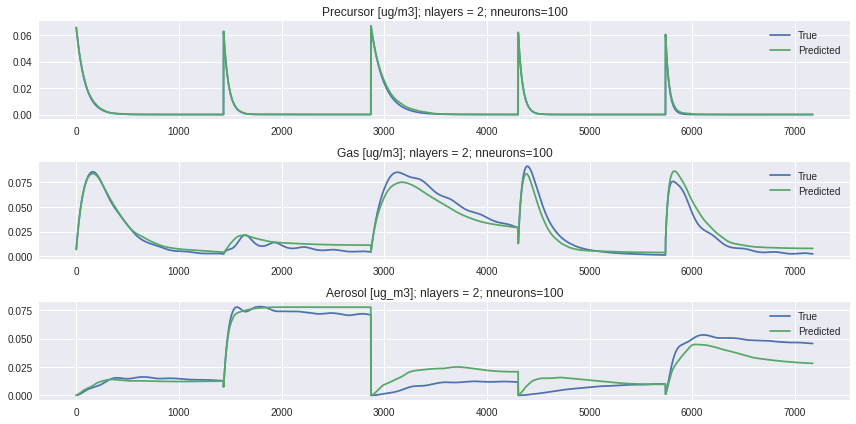

In [9]:
vnames = test.keys().to_list()
# Split plots by variable to compare
fig,axs = plt.subplots(3,1,figsize=(12,6))

for i in range(3):
    lab = vnames[i+1]
    
    plt.subplot(3,1,i+1)
    
    plt.plot(true_box.iloc[:,i],label="True")
    plt.plot(pred_box.iloc[:,i],label="Predicted")
    plt.title(lab+"; nlayers = 2; nneurons=100")
    plt.legend()
plt.tight_layout()
plt.style.use('seaborn')

Below are some work in progress.

In [ ]:
# Following this tutorial for multivariate data, building a simple LTSM model
# https://www.tensorflow.org/tutorials/structured_data/time_series

# Get variable names and relevant features
vnames = test.keys().to_list()
features_considered = vnames[1:4]

# Function to window a timeseries of multivariate data
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

    if single_step:
        labels.append(target[i+target_size])
    else:
        labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)


# set sequence options
past_history  = 720
future_target = 72
STEP          = 6


In [ ]:
# Attempt to build CNN Model (Currently not working--need to work on preprocessing time series and splitting appropriately)
# Reference Provided by Charlie

from tensorflow.keras import layers
trainshape = scaled_train_in.shape

batchsize=256 
filters     = 64 # Dimensionality of output Space
kernel_size =  3 # Size of the kernel
strides     = 1 # Stride length
activation  = "relu"
n_timesteps = trainshape[0]
n_features  = trainshape[1]
pool_size   = 2
n_outputs   = 3
n_neurons   = 100


# Get input shape
input_layer = Input(n_features)

# Initialize model
modcnn=tf.keras.models.Sequential()

# Add 2 layers (give model good chance of learning features?)
modcnn.add(layers.Conv1D(filters,kernel_size,strides=strides,activation=activation,input_shape=(batchsize,n_features)))
modcnn.add(layers.Conv1D(filters,kernel_size,strides=strides,activation=activation))

# Add droupout layer for regularization?
modcnn.add(layers.Dropout(0.5))

# Add pooling layer for dimension reduction
modcnn.add(layers.MaxPooling1D(pool_size))

# Flatten learned features
modcnn.add(layers.Flatten())

# Add fully connected layer before preduction
modcnn.add(Dense(n_neurons,activation="relu"))
modcnn.add(Dense(n_outputs,activation="softmax"))

# # Get input layer shape
# trainshape = scaled_train_in.shape
# input_shape = (batchsize,trainshape[0],trainshape[1])

# # Create First layer
# x = tf.random.normal(input_shape)

# # For first layer, include input shape
# tf.keras.layers.Conv1D(filters,kernal_size,strides,activation=activation,input_shape=input_shape)(x)
modcnn.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 254, 64)           1792      
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 252, 64)           12352     
_________________________________________________________________
dropout_1 (Dropout)          (None, 252, 64)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 126, 64)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8064)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               806500    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                

### Wednesday
* Calculate three relevant evaluation metrics for each ML solution and baseline
* Refine machine learning approaches and test additional hyperparameter settings

In [ ]:
#Wednesday's code goes here


### Thursday 
* Evaluate two interpretation methods for your machine learning solution
* Compare interpretation of baseline with your approach
* Submit best results on project to leaderboard
* Prepare 2 Google Slides on team's approach and submit them 

In [ ]:
#Thursday's code goes here


## Ultimate Submission Code
Please insert your full data processing and machine learning pipeline code in the cell below.